# Preparation

In [1]:
# Importing required libraries
from tqdm import tqdm
import time
import numpy as np
import matplotlib.pyplot as plt
import random
import py_dss_interface
from time import perf_counter

## DSS Interface Creation

In [2]:
dss = py_dss_interface.DSS()
#opendss_path = "C:/Users/jcuenca/AppData/Local/Programs/OpenDSS"
dss = py_dss_interface.DSS(opendss_path)

## Create DSS Model

In [3]:
# Master file path
#dss_file = "C:/Users/jcuenca/Documents/Tests/EDEN4SG/OpenDSS_DataGen/European_LV_DSS/Master_3ph.dss" 
# Compile and generate circuit
dss.text("compile {}".format(dss_file))
dss.text("solve")


''

# Dataset Generator (Random operational points)

## Parameters and initalise variables

In [4]:
# Variables
load_kw_rated = np.array(range(dss.loads.count), dtype=float)
amp_ratings = np.array(range(dss.lines.count), dtype=float)

# Extract base loads
dss.loads.first()
for load in (range(dss.loads.count)):
    load_kw_rated[load] = dss.loads.kw # Get nominal load rating
    dss.loads.next()

# Amp limits in lines
dss.lines.first()
for line in (range(dss.lines.count)):
    amp_ratings[line] = dss.lines.norm_amps # Get nominal load rating
    dss.lines.next()

# Volt limits in buses
max_v_pu =np.full((int(len(dss.circuit.buses_vmag_pu)/3)), 1.1) # Maximum voltage p.u. value is 1.1
min_v_pu =np.full((int(len(dss.circuit.buses_vmag_pu)/3)), 0.9) # Minimum voltage p.u. value is 0.9

# Number of loads
n_loads = dss.loads.count

# Set upper and lower bound for base loads (e.g., 20% - 450%)
max_loads = load_kw_rated*4.5
min_loads = load_kw_rated*0.2

# Set step for load changes (e.g., 500 W)
#load_step = 0.5 

# Number of operational points (OP) to generate (i.e., dataset size)
#n_op = 10000

## Load profiles to study...

In [5]:
# Get data that from first profiles
#data_directory = "D:/Data/ELVTN_Datasets/val_profiles/input/"

# Get injections
#ALL_OPS = np.loadtxt(open(data_directory + "input_injections_kW.csv", "rb"), delimiter=",", skiprows=0)

## ... or build profiles to study

In [6]:
# Data directory for all possible profiles
data_directory = EV_dir + "Load_profile_"

# How many days of simulations 
#n_days = 7

# Initialise 
ALL_OPS = np.copy(min_loads)
#curr_profile = np.arange(1440)[:, np.newaxis]
curr_profile = np.arange(1440)

for day in (range(n_days)): # For each day do...
    day_profile_ids = np.random.randint(1, 100, len(min_loads)) # Generate random ids for profiles
    day_profiles = np.copy(curr_profile)
    for prof in (range(n_loads)) : # For each load
        curr_profile = np.loadtxt(open(data_directory + np.array2string(day_profile_ids[prof], precision=0) + ".csv", "rb"), delimiter=",", usecols= 1, skiprows=1)
        day_profiles = np.vstack(([day_profiles, curr_profile]))

    day_profiles = np.delete(day_profiles, 0, 0)
    
    ALL_OPS = np.vstack([ALL_OPS, np.transpose(day_profiles)])

ALL_OPS = np.delete(ALL_OPS, 0, 0)

n_op = len(ALL_OPS)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 27.97it/s]


## Now generate EV profiles

In [7]:
# How many days of simulations 

# EV simulation data
EV_pen = 1 # Percentage of households that own an EV
EV_freq = 4 / 7 # How often is the EV branched for charging (e.g., 7 out of 7 days)
EV_arriv_mean, EV_arriv_stdv = 20*60, 2.5*60 # Arrival times - normal distribution (minutes) e.g., mean 8pm, std deviation 2h
EV_min_charge, EV_max_charge = 30, 250 # Range of daily charging minutes required - associated to EV use the day(s) before

# Simulate which customers have EVs
EV_indices = np.random.permutation(n_loads) # Random permutations for EV location
nr_samples = len(EV_indices) # How many samples are there
size_w_EV = int(np.rint(EV_pen * nr_samples)) # Define the size of the EV pool
EV_idx, noEV_idx = EV_indices[:size_w_EV], EV_indices[size_w_EV:] # Define indices of EV buses

ALL_EVS =np.zeros_like(ALL_OPS) # Create storing variable

# Generate actual adding 
for day in (range(n_days)): # For each day do...
    EV_arriv = (np.random.normal(EV_arriv_mean, EV_arriv_stdv, (np.round(n_loads*EV_pen)).astype(int))).astype(int) # Generate EV arrival data
    #EV_arriv = np.round(EV_arriv)
    EV_day_charge = np.random.randint(EV_min_charge, high=EV_max_charge, size=np.round(n_loads*EV_pen).astype(int)) # Generate EV charging needs (minutes)
    
    for EV in range(len(EV_arriv)): # For each EV 
        if EV_arriv[EV] < 0: # Normalise arrival time
            EV_arriv[EV] = 0
        elif EV_arriv[EV] > 1440:
            EV_arriv[EV] = 1440
        if np.random.rand(1) > EV_freq: # Randomly check if this is a charge day and continue if not
            continue
        if day == n_days and EV_arriv[EV]+EV_day_charge[EV] > 1440: # Additional condition for the last day
            ALL_EVS[day*1440+EV_arriv[EV]:][EV_indices[EV]] = 7
            continue
        ALL_EVS[day*1440+EV_arriv[EV]:day*1440+EV_arriv[EV]+EV_day_charge[EV], EV_indices[EV]] = 7 # Charge active power in kW



100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<?, ?it/s]


## ... and add these profiles on top of non-flexible loads

In [9]:
ALL_OPS = ALL_OPS + ALL_EVS

## PF Simulator to label OPs

In [10]:
dss.text("set mode=snap")

# Batch directory
batch_dir = (test_dir + "batches/")
N_batches = 1000 # This is done to improve performance of data generation

#Rand_OPS = np.random.rand(n_op,n_loads) # Randomly generate operational points (i.e., injections)
#ALL_OPS = (max_loads - min_loads) * Rand_OPS + min_loads
safe=0 # Counter for safe operational points
unsafe=0 # Counter for unsafe operational points

alllineamps = np.array(range(dss.lines.count), dtype=float) # Variable for all line currents (amps)
allbusvolts = np.array(range(len(dss.circuit.buses_vmag_pu)), dtype=float) # Variable for all bus voltages (p.u.)
allbusvolts = np.reshape(allbusvolts, (int(len(dss.circuit.buses_vmag_pu)/3), 3)) # Reshape from 3phase
allbusvolts = np.mean(allbusvolts, axis = 1) # Mean voltage of three phases

# Variables useful for training
#ALL_REGRESS = np.hstack([allbusvolts, alllineamps]) # Variable to store bus votlages and line currents for regression
ALL_CLASSIF = np.empty(1)

# Start timers
t_data = 0
t_pf = 0
t_verif = 0
t_tot = 0
t_ini = perf_counter()

print("------- Generating data in batches -------")

for batch in tqdm(range(N_batches)):
    Rand_OPS = np.random.rand(np.int32(n_op/N_batches),n_loads) # Randomly generate operational points (i.e., injections)
    ALL_OPS = (max_loads - min_loads) * Rand_OPS + min_loads
    #ALL_REGRESS = np.hstack([allbusvolts, alllineamps]) # Variable to store bus votlages and line currents for regression ## UNCOMMENT FOR REGRESSION
    ALL_CLASSIF = np.empty(1)

    for op in (range(np.int32(n_op/N_batches))): # For each operational point do...
        # Get next OP
        next_OP = ALL_OPS[op]
    
        t0 = perf_counter() # start timer
        
        # Assign load in electrical model
        dss.loads.first()
        for load in range(dss.loads.count):
            dss.loads.kw = next_OP[load]
            dss.loads.next()
    
        t1 = perf_counter() # time load changes  
        
        # Solve PF for current OP
        dss.text("solve")
        
        t2 = perf_counter() # time power flow
        
        # Get current magnitudes (amperes)
        dss.lines.first()
        for line in range(dss.lines.count):
            alllineamps[line] = dss.cktelement.currents_mag_ang[0] 
            dss.lines.next()
        
        # Get voltage magnitudes p.u.
        allbusvolts = dss.circuit.buses_vmag_pu 
        allbusvolts = np.reshape(allbusvolts, (int(len(dss.circuit.buses_vmag_pu)/3), 3)) 
        allbusvolts = np.mean(allbusvolts, axis = 1)
    
        # Store voltage pu and current magnitudes 
        #allbusvolt_lineamps = np.hstack([allbusvolts, alllineamps]) # Store bus voltages and line currents
        
        t3 = perf_counter() # timer obtain results    
        
        if all(alllineamps < amp_ratings) and all(allbusvolts < max_v_pu) and all(allbusvolts > min_v_pu) : # If constraints are respected do..-
            #print("safe")
            ALL_CLASSIF = np.vstack([ALL_CLASSIF, 0]) # Labelling safe point
            safe += 1 # Count safe scenarios 
            
        else: # If at least one constraint is not respected do...
            #print("unsafe") # Count unsafe scenarios
            ALL_CLASSIF = np.vstack([ALL_CLASSIF, 1]) # Labelling unsafe point
            unsafe += 1 # Count unsafe scenarios 
                
        #ALL_OPS = np.vstack([ALL_OPS, next_OP]) # Store OPs (injections)
        #ALL_REGRESS = np.vstack([ALL_REGRESS, allbusvolt_lineamps]) # Store regression values (volt pu and line currents amps)
    
        t4 = perf_counter()
    
        
        t_data = t_data + t3 - t2 + t1 - t0
        t_pf = t_pf + t2 - t1
        t_verif = t_verif + t4 - t3
    
    #t_tot = t4 - t_ini

    # Delete initialisation data row
    ALL_CLASSIF = np.delete(ALL_CLASSIF, 0, 0)
    
    # Get injections
    #ALL_OPS = np.loadtxt(open(data_directory + "input_injections_kW.csv", "rb"), delimiter=",", skiprows=0)
    np.savetxt(batch_dir + "A_" + str(batch) + ".csv", ALL_OPS, delimiter=",")
    #np.savetxt(batch_dir + "B_" + str(batch) + ".csv", ALL_REGRESS, delimiter=",") ## UNCOMMENT FOR REGRESSION
    np.savetxt(batch_dir + "C_" + str(batch) + ".csv", ALL_CLASSIF, delimiter=",")

t_tot = perf_counter() - t_ini

100%|███████████████████████████████████████████████████████████████████████████| 10080/10080 [01:31<00:00, 109.62it/s]


## Analysis of computational time

In [11]:
print("------- OpenDSS analysis -------")
print("To study", n_op, "operational points...")
print("Total execution time:", t_tot, "seconds")
print("Total data exchange time:", t_data, "seconds")
#print("Percentage :", 100*t_data/t_tot, "%")
print("Total power flow time:", t_pf, "seconds")
#print("Percentage :", 100*t_pf/t_tot, "%")
print("Total labellisation time:", t_verif, "seconds")
#print("Percentage :", 100*t_verif/t_tot, "%")
INFO_SIM = [n_op, unsafe, t_tot, t_data, t_pf, t_verif]

------- OpenDSS analysis -------
To study 10080 operational points...
Total execution time: 91.9564965 seconds
Total data exchange time: 85.86737070000025 seconds
Percentage : 93.37825381374795 %
Total power flow time: 4.2409399999998385 seconds
Percentage : 4.611898192532638 %
Total labellisation time: 0.7021103999998815 seconds
Percentage : 0.7635245216197221 %


## Save the stored data

In [12]:
print("------- Regrouping batches -------")

ALL_OPS = np.copy(min_loads)
#ALL_REGRESS = np.hstack([allbusvolts, alllineamps]) # Variable to store bus votlages and line currents for regression ## UNCOMMENT FOR REGRESSION
ALL_CLASSIF = 0

# Call the batches for storing
for batch in tqdm(range(N_batches)):
    ALL_OPS_save = np.loadtxt(open(batch_dir + "A_" + str(batch) + ".csv", "rb"), delimiter=",", skiprows=0)
    ALL_OPS = np.vstack([ALL_OPS, ALL_OPS_save])
    #ALL_REGRESS_save = np.loadtxt(open(batch_dir + "B_" + str(batch) + ".csv", "rb"), delimiter=",", skiprows=0) ## UNCOMMENT FOR REGRESSION
    #ALL_REGRESS = np.vstack([ALL_REGRESS, ALL_REGRESS_save]) ## UNCOMMENT FOR REGRESSION
    ALL_CLASSIF_save = np.loadtxt(open(batch_dir + "C_" + str(batch) + ".csv", "rb"), delimiter=",", skiprows=0)
    ALL_CLASSIF = np.hstack([ALL_CLASSIF, ALL_CLASSIF_save])
    
# Delete initialisation data row
ALL_CLASSIF = np.delete(ALL_CLASSIF, 0, 0)
#ALL_REGRESS = np.delete(ALL_REGRESS, 0, 0) ## UNCOMMENT FOR REGRESSION
ALL_OPS = np.delete(ALL_OPS, 0, 0)

# Store input, classification output and regression output
np.savetxt(test_dir + "Val_ProfilesEV/input_injections_kW.csv", ALL_OPS, delimiter=",")
#np.savetxt("D:/Data/ELVTN_Datasets/1_Random/output_regression_busvpu_lineamp.csv", ALL_REGRESS, delimiter=",") ## UNCOMMENT FOR REGRESSION
np.savetxt(test_dir + "Val_ProfilesEV/output_classification_notsafe.csv", ALL_CLASSIF, delimiter=",")
np.savetxt(test_dir + "Val_ProfilesEV/info.csv", INFO_SIM, delimiter=",")

## Analysis of Operational Points Generated

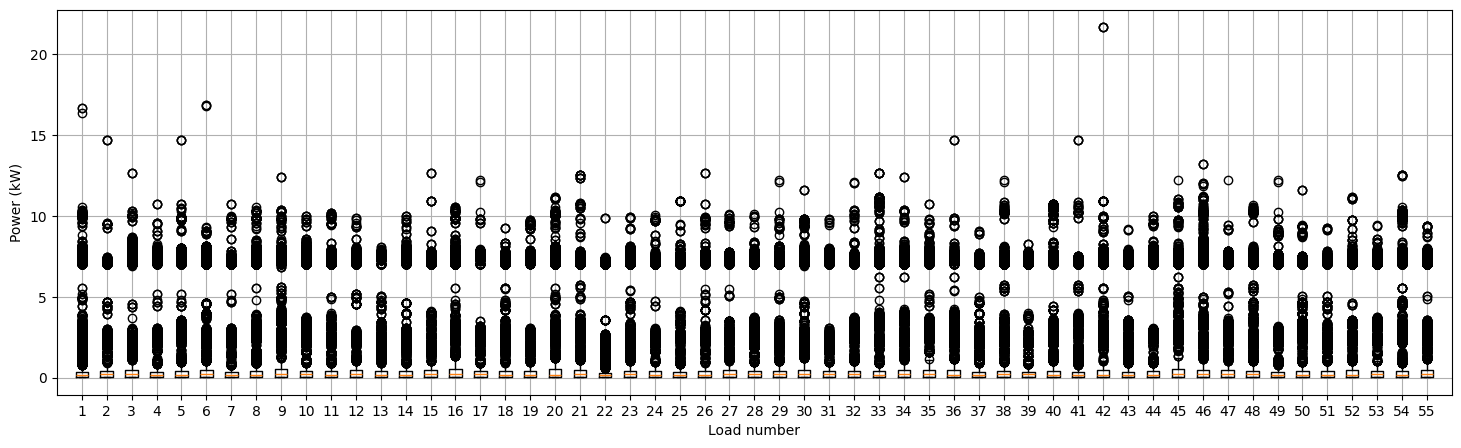

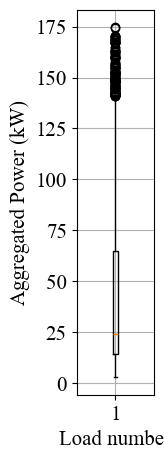

9854 safe operational points generated
226 unsafe operational points generated
Of the  10080  operational points generated,  3.6309523809523814 % are repeated


In [13]:
# Count repeated points
unq, count = np.unique(ALL_OPS, axis=0, return_counts=True)
print("Of the ", n_op, " operational points generated, ", len(unq[count>1])/n_op*100, "% are repeated")